# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-4 below, which you need to complete as instructed.

**Refer to the material in units 7-8 for conceptual background.**

In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!
shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"
all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394


In [4]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [5]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [6]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [7]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs  = create_character_document_from_dataframe(train_data, max_line_count=360)
train_character_docs
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [8]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    tokens = character_text.split()   # just a simple tokenization, to be replaced
    return tokens

In [9]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
print(train_labels)

['CHRISTIAN', 'CLARE', 'HEATHER', 'IAN', 'JACK', 'JANE', 'MAX', 'MINTY', 'OTHER', 'PHIL', 'RONNIE', 'ROXY', 'SEAN', 'SHIRLEY', 'STACEY', 'TANYA']


In [10]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
#     counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return dict(counts)

In [11]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# corpusVectorizer = TfidfVectorizer(max_df = 0.5, ngram_range = (2,2)) 

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [12]:
training_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 20749 stored elements in Compressed Sparse Row format>

In [13]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [14]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [15]:
val_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 3618 stored elements in Compressed Sparse Row format>

In [16]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [17]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [18]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [19]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 4.5
mean cosine similarity 0.9128136458100018
4 correct out of 16 / accuracy: 0.25


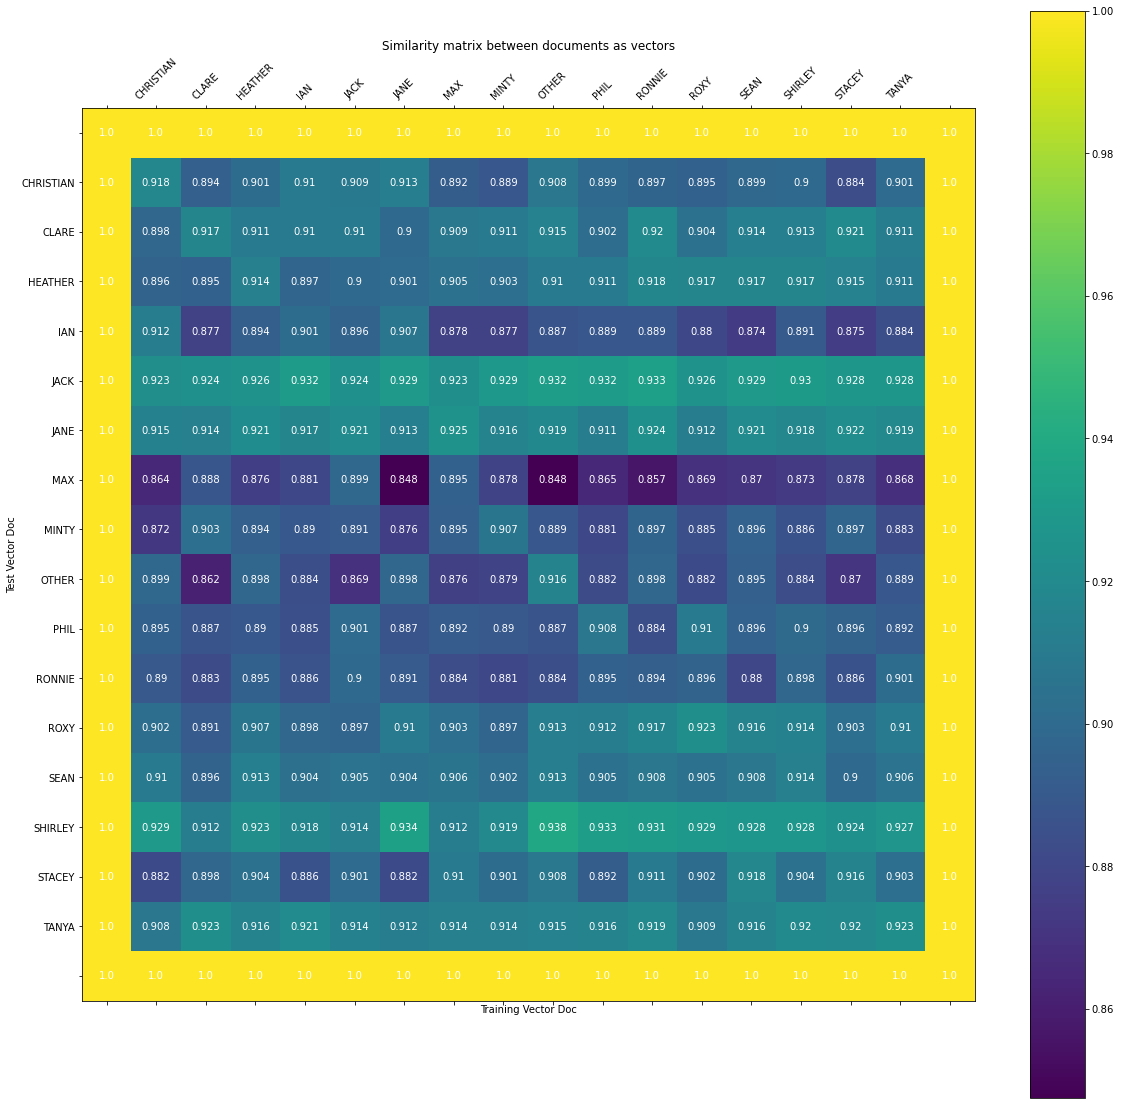

In [20]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (10 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [21]:
# Build the original train_data
raw_train_data_q1 = train_data.drop("train_heldout", axis = 1).drop("episode_scene", axis = 1)

In [22]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column_q1 = raw_train_data_q1.Episode.astype(str) + "-" + raw_train_data_q1.Scene.astype(str)
raw_train_data_q1['episode_scene'] = epsiode_scene_column_q1
episode_scenes_q1 = sorted(list(set([x for x in epsiode_scene_column_q1.values]))) # set function is random, need to sort!
shuffle(episode_scenes_q1)

print(len(episode_scenes_q1))
episode_split_q1 = int(0.9*len(episode_scenes_q1))
training_ep_scenes_q1 = episode_scenes_q1[:episode_split_q1]
val_ep_scenes_q1 = episode_scenes_q1[episode_split_q1:]

def train_or_heldout_eps_q1(val):
    if val in training_ep_scenes_q1:
        return "training"
    return "heldout"
raw_train_data_q1['train_heldout'] = raw_train_data_q1['episode_scene'].apply(train_or_heldout_eps_q1)

1254


In [23]:
print('Raw Data: ',np.shape(raw_train_data_q1))
train_data_q1 = raw_train_data_q1[raw_train_data_q1['train_heldout']=='training']
val_data_q1 = raw_train_data_q1[raw_train_data_q1['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data_q1))
print('Validation set: ',np.shape(val_data_q1))

Raw Data:  (13638, 8)
Train set:  (12135, 8)
Validation set:  (1503, 8)


In [24]:
train_character_docs_q1 = create_character_document_from_dataframe(train_data_q1, max_line_count = 360)
print('Num. Characters: ', len(train_character_docs_q1.keys()), "\n")
total_words_q1 = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ', len(train_character_docs_q1[name].split()))
    total_words_q1 += len(train_character_docs_q1[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 325, 'HEATHER': 317, 'JACK': 360, 'RONNIE': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 345, 'CHRISTIAN': 308, 'CLARE': 318}
Num. Characters:  16 

SHIRLEY Number of Words:  3805
OTHER Number of Words:  3178
JACK Number of Words:  4419
RONNIE Number of Words:  3282
TANYA Number of Words:  3794
SEAN Number of Words:  3484
ROXY Number of Words:  3465
HEATHER Number of Words:  3507
MAX Number of Words:  4449
IAN Number of Words:  4296
JANE Number of Words:  3666
STACEY Number of Words:  3873
PHIL Number of Words:  3645
MINTY Number of Words:  3862
CHRISTIAN Number of Words:  3314
CLARE Number of Words:  3871
total words 7062


In [25]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [26]:
contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expand_contractions(s, contractions=contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

# table = str.maketrans({key: None for key in string.punctuation}) #returns a mapping table for translation using unicode ordinal



In [27]:
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
def pre_process_q1(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    character_text = expand_contractions(character_text) #xall the function to expand contractions
    character_text = re.sub('\W', ' ', character_text) #remove all special character
    character_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', character_text) #remove single character like 's
    character_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', character_text) #remove single character from the start
    character_text.lower()
    character_text = re.sub('[\s]+', ' ', character_text, flags=re.I)
    character_text = re.sub('[\n]+', ' ', character_text)
#     character_text = ' '.join(character_text.split()) 
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(character_text)    
    # lowercasing
    tokens = [t.lower() for t in tokens]
    # stopword removal
    stop_words = set(stopwords.words('english'))
    stop = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop]
    
    # lemmatisation
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(t) for t in tokens]

    return tokens
print(pre_process_q1("hello this is the, ehh... presumably, a crying situations!"))

['hello', 'ehh', 'presumably', 'cry', 'situation']


In [28]:
# from nltk.corpus import stopwords
# from nltk import PorterStemmer
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import RegexpTokenizer

# def pre_process_q1(character_text):
#     """Pre-process all the concatenated lines of a character, 
#     using tokenization, spelling normalization and other techniques.
    
#     Initially just a tokenization on white space. Improve this for Q1.
    
#     ::character_text:: a string with all of one character's lines
#     """
#     tokenizer = RegexpTokenizer(r'\w+')

#     tokens = tokenizer.tokenize(character_text)   # just a simple tokenization, to be replaced
#     token_preprocessed = []
#     # lowercasing
#     tokens = [t.lower() for t in tokens]
#     # stopword removal
#     stop = set(stopwords.words('english'))
#     print(stop)
#     tokens = [t for t in tokens if t not in stop]
    
#     # lemmatisation
#     lemmatiser = WordNetLemmatizer()
#     tokens = [lemmatiser.lemmatize(t) for t in tokens]
    
#     # stemmer
#     stemmer = PorterStemmer()
#     tokens = [stemmer.stem(t) for t in tokens]
    
#     return tokens
# print(pre_process_q1("hello this is the, ehh... presumably, a crying situations!"))

In [29]:
training_corpus_q1 = [(name, pre_process_q1(doc)) for name, doc in sorted(train_character_docs_q1.items())]
train_labels_q1 = [name for name, doc in training_corpus]
print(train_labels_q1)

['CHRISTIAN', 'CLARE', 'HEATHER', 'IAN', 'JACK', 'JANE', 'MAX', 'MINTY', 'OTHER', 'PHIL', 'RONNIE', 'ROXY', 'SEAN', 'SHIRLEY', 'STACEY', 'TANYA']


In [30]:
corpusVectorizer_q1 = DictVectorizer()
training_feature_matrix_q1 = create_document_matrix_from_corpus(training_corpus_q1, fitting = True)

In [31]:
val_character_docs_q1 = create_character_document_from_dataframe(val_data_q1, max_line_count = 40)
print("Num. charactoers", len(val_character_docs_q1.keys()), "\n")
total_words_q1 = 0
for name in val_character_docs_q1.keys():
    print(name, "Number Of Words: ", len(val_character_docs_q1[name].split()))
    total_words_q1 += len(val_character_docs_q1[name].split())
print("total_words", total_words)


lines per character {'JACK': 28, 'RONNIE': 30, 'OTHER': 40, 'TANYA': 40, 'MAX': 40, 'JANE': 40, 'IAN': 40, 'HEATHER': 40, 'SHIRLEY': 40, 'SEAN': 40, 'ROXY': 40, 'PHIL': 24, 'CHRISTIAN': 34, 'MINTY': 40, 'CLARE': 34, 'STACEY': 37}
Num. charactoers 16 

JACK Number Of Words:  332
RONNIE Number Of Words:  423
OTHER Number Of Words:  330
TANYA Number Of Words:  354
MAX Number Of Words:  486
JANE Number Of Words:  413
IAN Number Of Words:  444
HEATHER Number Of Words:  434
SHIRLEY Number Of Words:  435
SEAN Number Of Words:  439
ROXY Number Of Words:  424
PHIL Number Of Words:  262
CHRISTIAN Number Of Words:  424
MINTY Number Of Words:  424
CLARE Number Of Words:  473
STACEY Number Of Words:  384
total_words 7062


In [32]:
val_corpus_q1 = [(name, pre_process_q1(doc)) for name, doc in val_character_docs_q1.items()]
val_labels_q1 = [name for name, doc in val_corpus_q1]

In [33]:
val_feature_matrix_q1 = create_document_matrix_from_corpus(val_corpus_q1, fitting=False)
mean_rank_q1, mean_cosine_simliarity_q1, acc_q1, df_q1 = compute_IR_evaluation_scores(training_feature_matrix_q1, val_feature_matrix_q1, train_labels_q1, val_labels_q1)

mean rank 1.4375
mean cosine similarity 0.9378721728052695
12 correct out of 16 / accuracy: 0.75


# Q2. Improve linguistic feature extraction (15 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

In [34]:
from nltk.util import ngrams
def to_feature_vector_dictionary_q2(character_doc, extra_features=["ngrams"]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
#     print(character_doc)
    test = []
    for each in character_doc:
        if each != "_eol_":
            test.append(each)
    counts = Counter(character_doc)  # for now a simple count
    if "ngrams" in extra_features:
        n_grams = []
        n_grams.extend([" ".join(x) for x in ngrams(character_doc, 2)])
        counts_ngram = Counter(n_grams)
        counts.update(counts_ngram)
    if "pos_tags" in extra_features:
        tags = set(['MD', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RP', 'RB', 'RBR', 'RBS', 'JJ', 'JJR', 'JJS'])
        ptags = []
        for w, ptag in nltk.pos_tag(character_doc):
            if w != "_eol_":
                ptags.append(w + '_' + ptag)
    
        counts.update(Counter(ptags))
#     print(dict(counts))
    return dict(counts)

In [35]:
# training_feature_matrix_q2 = create_document_matrix_from_corpus(training_corpus_q1, fitting = True)

In [36]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# corpusVectorizer = TfidfVectorizer(max_df = 0.5, ngram_range = (2,2)) 
from sklearn.feature_selection import SelectKBest
def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary_q2(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary_q2(doc) for name, doc in corpus])
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

# training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)


In [37]:
training_corpus_q2 = [(name, pre_process_q1(doc)) for name, doc in sorted(train_character_docs_q1.items())]
train_labels_q2 = [name for name, doc in training_corpus_q2]
val_corpus_q2 = [(name, pre_process_q1(doc)) for name, doc in val_character_docs_q1.items()]
val_labels_q2 = [name for name, doc in val_corpus_q2]

In [38]:
training_feature_matrix_q2 = create_document_matrix_from_corpus(training_corpus_q2, fitting = True)
test_feature_matrix_q2 = create_document_matrix_from_corpus(val_corpus_q2, fitting=False)
mean_rank_q2, mean_cosine_simliarity_q2, acc_q2, df_q2 = compute_IR_evaluation_scores(training_feature_matrix_q2, test_feature_matrix_q2, train_labels_q2, val_labels_q2)

mean rank 1.5625
mean cosine similarity 0.9055248177226546
13 correct out of 16 / accuracy: 0.8125


# Q3. Add dialogue context data and features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). You can also use **scene information** from the other columns **(but NOT the gender and character names directly)**.

In [39]:
# Create one document per character
def create_character_document_from_dataframe_q3(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    episode_scene_line_dict = {}
    for line, episode_scene in zip(df.Line, df.episode_scene):
        if episode_scene not in episode_scene_line_dict:
            episode_scene_line_dict[episode_scene] = []
        episode_scene_line_dict[episode_scene].append(str(line))
    for line, name, gender, episode_scene in zip(df.Line, df.Character_name, df.Gender, df.episode_scene):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)     # adding an end-of-line token
        if episode_scene in episode_scene_line_dict:
            context = ""
            curr = episode_scene_line_dict[episode_scene]
            for sentence in curr:
                if sentence != str(line):
                    context = context + " _CONTEXT_ " + str(sentence)
            character_docs[name] += context
            character_docs[name] += " _EOL_ "
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [40]:
from nltk.util import ngrams
def to_feature_vector_dictionary_q3(character_doc, extra_features=["ngrams"]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
#     print(character_doc)
    test = []
    for each in character_doc:
        if each != "_eol_":
            test.append(each)
    counts = Counter(character_doc)  # for now a simple count
    if "ngrams" in extra_features:
        n_grams = []
        n_grams.extend([" ".join(x) for x in ngrams(character_doc, 2)])
        counts_ngram = Counter(n_grams)
        counts.update(counts_ngram)
    if "pos_tags" in extra_features:
        tags = set(['MD', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RP', 'RB', 'RBR', 'RBS', 'JJ', 'JJR', 'JJS'])
        ptags = []
        for w, ptag in nltk.pos_tag(character_doc):
            if w != "_eol_" and w != "_context_":
                ptags.append(w + '_' + ptag)
    
        counts.update(Counter(ptags))
    print(dict(counts))
    return dict(counts)

In [41]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# corpusVectorizer = TfidfVectorizer(max_df = 0.5, ngram_range = (2,2)) 
from sklearn.feature_selection import SelectKBest
def create_document_matrix_from_corpus_q3(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary_q3(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary_q3(doc) for name, doc in corpus])
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

In [42]:
train_character_docs_q3= create_character_document_from_dataframe_q3(train_data_q1, 360)
training_corpus_q3 = [(name, pre_process_q1(doc)) for name, doc in train_character_docs_q3.items()]
train_labels_q3 = [name for name, doc in training_corpus_q3]
training_feature_matrix_q3 = create_document_matrix_from_corpus_q3(training_corpus_q3, fitting=True)

val_character_docs_q3= create_character_document_from_dataframe_q3(val_data_q1, 360)
val_corpus_q3 = [(name, pre_process_q1(doc)) for name, doc in val_character_docs_q3.items()]
val_labels_q3 = [name for name, doc in val_corpus_q3]
val_feature_matrix_q3 = create_document_matrix_from_corpus_q3(val_corpus_q3, fitting=False)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 325, 'HEATHER': 317, 'JACK': 360, 'RONNIE': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 345, 'CHRISTIAN': 308, 'CLARE': 318}
{'look': 355, 'ya': 105, 'mark': 1, 'think': 183, 'unlucky': 1, 'man': 16, '_context_': 6584, 'shirl': 92, '_eol_': 360, 'gonna': 264, 'get': 459, 'help': 66, 'oh': 285, 'phone': 28, 'kevin': 135, 'smashed': 9, 'going': 168, 'right': 177, 'pocket': 9, 'done': 81, 'ssh': 9, 'shut': 86, 'fire': 12, 'brigade': 9, 'ambulance': 51, 'accident': 11, 'industrial': 18, 'estate': 18, 'walford': 20, 'um': 63, 'marsh': 9, 'lane': 9, 'please': 124, 'come': 312, 'quick': 88, 'husband': 36, 'friend': 43, 'trapped': 9, 'car': 46, 'shirley': 88, 'carter': 16, '82': 9, '82b': 9, 'george': 9, 'street': 9, 'e20': 9, 'hurry': 10, 'go': 583, 'main': 9, 'road': 11, 'make': 139, 'sure': 63, 'know': 463, 'shall': 369, 'five': 27, 'minute': 43, 'got': 331, 'sit': 50, 'w

{'maybe': 103, '_context_': 6126, 'perhaps': 20, 'cook': 8, 'something': 104, 'like': 299, 'martin': 8, 'auntie': 8, 'pauline': 8, 'know': 335, 'give': 76, 'holiday': 8, 'new': 59, 'year': 42, 'never': 83, 'get': 327, 'plus': 8, 'going': 190, 'moving': 10, 'today': 24, 'thinking': 42, 'shall': 265, 'later': 62, 'week': 97, 'le': 16, 'lucy': 48, 'keep': 35, 'changing': 10, 'channel': 8, 'co': 43, 'boring': 29, 'matter': 33, 'set': 13, 'oven': 8, 'timer': 8, 'find': 43, 'two': 65, 'cannot': 101, 'decide': 8, 'lazy': 8, 'town': 14, 'bobby': 42, 'cafe': 24, '_eol_': 360, 'way': 66, 'please': 52, 'go': 258, 'home': 36, 'everyone': 47, 'walking': 3, 'around': 33, 'hardly': 19, 'anywhere': 6, 'open': 7, 'cold': 3, 'could': 107, 'really': 165, 'cup': 13, 'tea': 13, 'thanks': 92, 'bad': 12, 'usual': 14, 'suppose': 48, 'sitting': 13, 'wondering': 6, 'hit': 3, 'feeling': 6, 'away': 50, 'ever': 33, 'still': 90, 'time': 173, 'heals': 3, 'say': 127, 'though': 11, 'sit': 11, 'back': 80, 'okay': 40, '

{'look': 355, 'ya': 105, 'mark': 1, 'think': 183, 'unlucky': 1, 'man': 16, '_context_': 6584, 'shirl': 92, '_eol_': 360, 'gonna': 264, 'get': 459, 'help': 66, 'oh': 285, 'phone': 28, 'kevin': 135, 'smashed': 9, 'going': 168, 'right': 177, 'pocket': 9, 'done': 81, 'ssh': 9, 'shut': 86, 'fire': 12, 'brigade': 9, 'ambulance': 51, 'accident': 11, 'industrial': 18, 'estate': 18, 'walford': 20, 'um': 63, 'marsh': 9, 'lane': 9, 'please': 124, 'come': 312, 'quick': 88, 'husband': 36, 'friend': 43, 'trapped': 9, 'car': 46, 'shirley': 88, 'carter': 16, '82': 9, '82b': 9, 'george': 9, 'street': 9, 'e20': 9, 'hurry': 10, 'go': 583, 'main': 9, 'road': 11, 'make': 139, 'sure': 63, 'know': 463, 'shall': 369, 'five': 27, 'minute': 43, 'got': 331, 'sit': 50, 'want': 413, 'fine': 78, 'talking': 39, 'life': 48, 'ask': 23, 'scared': 62, 'alright': 213, 'away': 113, 'yeah': 545, 'told': 143, 'say': 233, 'nightmare': 26, 'asked': 70, 'window': 52, 'changed': 37, 'something': 170, 'u': 167, 'course': 59, 'me

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [43]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix_q3, val_feature_matrix_q3, train_labels_q3, val_labels_q3)

mean rank 3.125
mean cosine similarity 0.9557207682336192
7 correct out of 16 / accuracy: 0.4375


# Q4. Improve the vectorization method (10 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfCorpusVectorizer = TfidfVectorizer(max_df = 0.5, ngram_range = (2,2)) 
def create_document_matrix_from_corpus_q4(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    def convert_from_dict_string(d):
        new_d = []
        for k,v in d.items():
            new_d.extend([k]*v)
        new_d = ' '.join(new_d)
        return new_d
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        tfidfCorpusVectorizer.fit([convert_from_dict_string(to_feature_vector_dictionary_q2(doc)) for name, doc in corpus])
    doc_feature_matrix = tfidfCorpusVectorizer.transform([convert_from_dict_string(to_feature_vector_dictionary_q2(doc)) for name, doc in corpus])
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

In [45]:
train_character_docs_q4= create_character_document_from_dataframe(train_data_q1, 360)
training_corpus_q4 = [(name, pre_process_q1(doc)) for name, doc in train_character_docs_q4.items()]
train_labels_q4 = [name for name, doc in training_corpus_q4]
training_feature_matrix_q4 = create_document_matrix_from_corpus_q4(training_corpus_q4, fitting=True)

val_character_docs_q4= create_character_document_from_dataframe(val_data_q1, 360)
val_corpus_q4 = [(name, pre_process_q1(doc)) for name, doc in val_character_docs_q4.items()]
val_labels_q4 = [name for name, doc in val_corpus_q4]
val_feature_matrix_q4 = create_document_matrix_from_corpus_q4(val_corpus_q4, fitting=False)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 325, 'HEATHER': 317, 'JACK': 360, 'RONNIE': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 345, 'CHRISTIAN': 308, 'CLARE': 318}
lines per character {'JACK': 28, 'RONNIE': 30, 'OTHER': 360, 'TANYA': 121, 'MAX': 81, 'JANE': 62, 'IAN': 81, 'HEATHER': 81, 'SHIRLEY': 62, 'SEAN': 56, 'ROXY': 43, 'PHIL': 24, 'CHRISTIAN': 34, 'MINTY': 50, 'CLARE': 34, 'STACEY': 37}


In [46]:
print(training_feature_matrix_q4.shape)
print(val_feature_matrix_q4.shape)

(16, 28489)
(16, 28489)


In [47]:
training_feature_matrix_q4 = create_document_matrix_from_corpus_q4(training_corpus_q4, fitting = True)
val_feature_matrix_q4 = create_document_matrix_from_corpus_q4(val_corpus_q4, fitting=False)
mean_rank_q4, mean_cosine_simliarity_q4, acc_q4, df_q4 = compute_IR_evaluation_scores(training_feature_matrix_q4, val_feature_matrix_q4, train_labels_q4, val_labels_q4)




mean rank 1.0625
mean cosine similarity 0.18841442357162197
15 correct out of 16 / accuracy: 0.9375


# Q5. Select and test the best vector representation method (10 marks)
Finish the optimization of your vector representations by selecting the best combination of the techniques you tried in Q1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [48]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process_q1(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus_q4(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process_q1(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus_q4(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
TANYA Number of Words:  4214
SEAN Number of Words:  4026
ROXY Number of Words:  4200
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters:  